# Phase Retrieval in dLux

In this notebook, we will go through a simple example of phase retrieval in dLux, just recovering Zernike coefficients for an aberrated circular aperture by gradient descent.

First, we import the necessary packages, including `Jax`:

Here is the core syntax of `dLux`: a list of optical layers. Unlike some other systems, we are *very* explicit about the whole optical system: 

- First initialize a wavefront using the `CreateWavefront` class. 
- For a simple circular aperutre extending the width of the wavefront we use the `ApertureFactory` class, specifying the the properties we want (ratio of primary to secondary mirror, number of struts etc), so it can pre-calculate the aperture and return the correct aperture class.
- We then want to apply the zernike aberrations using `AberrationFactory` to generate this class for us.
- To introduce our assymetry we add a `TransmissiveOptic` layer, feeding in the asymmetric array on ones and zeros we calcualted.
- We then normalise the flux to unitary power *after* the wavefront has passed through these two layers.
- Then we propagate our wavefront to a focal plane using the `AngularMFT` class, which defines pixel scale units in angular SI units, ie radians, specifying the number of pixels in the output detector.

In [1]:
# Core jax
import jax
import jax.numpy as np
import jax.random as jr

# Optimisation
import zodiax as zdx
import optax

# Optics
import dLux as dl
import dLux.utils as dlu

# Plotting/visualisation
import matplotlib.pyplot as plt
from matplotlib import colormaps
from tqdm.notebook import tqdm

%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 120

Now, we want to construct a basic optical system with a 1m aperture. 

We also generate a Zernike basis in order to model some optical aberrations, omitting the piston/tip/tilt elements, and initialising them as normally-distributed coefficients over that basis. 

As noted by [Martinache et al 2013](https://ui.adsabs.harvard.edu/abs/2013PASP..125..422M/abstract), you can only detect the sign of even-order aberrations if your pupil is not inversion-symmetric; so following that paper, we introduce a small bar asymmetry.

In [2]:
# Generate an Aperture
diameter = 2.4
wf_npixels = 256 
aperture = dl.ApertureFactory(wf_npixels, secondary_ratio=.2, nstruts=4, strut_ratio=1.5e-2)

# Generate an asymmetry
c, s = wf_npixels//2, 20
mask = np.ones((wf_npixels, wf_npixels)).at[c-s:c+s, :c].set(0)

# Define the aberrations
radial_terms = [2, 3]
coeffs = 1e-7*jr.normal(jr.PRNGKey(0), (7,))
aberrations = dl.AberrationFactory(wf_npixels, radial_terms, coeffs)

# Detector params
det_npixels = 256 
det_pixsize = dlu.arcsec_to_rad(1e-2)
propagator = dl.PropagatorFactory(det_npixels, det_pixsize)

# Construct Optics
optics = dl.FlexibleOptics(diameter, aperture, propagator, aberrations, mask)

Now we also need to create a source that we will be examining with this optical configuration. Here we use a simple point source, which is initialised on-axis, with a flux of one. We only need to define the wavelengths of this source, so lets have a look at the resulting object.

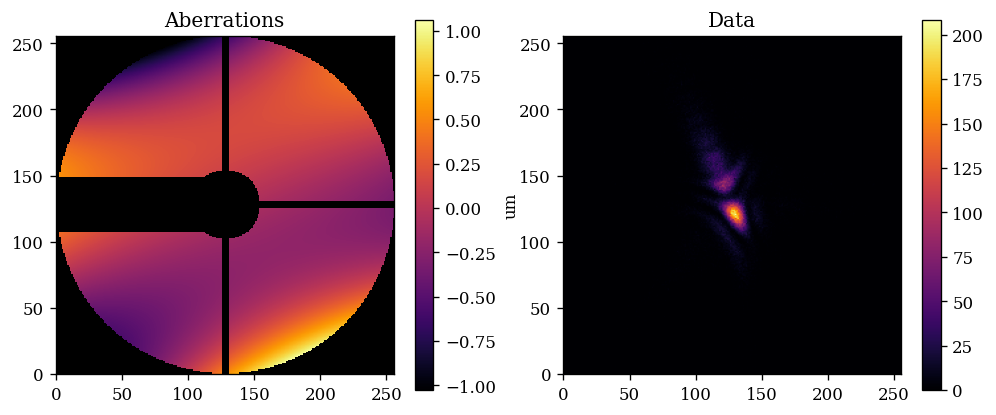

In [3]:
# Create a point source
wavels = np.linspace(1e-6, 1.5e-6, 5)
source = dl.PointSource(flux=1e5, wavelengths=wavels)

# Model the psf and add some photon noise
psf = optics.model(source)
data = jr.poisson(jr.PRNGKey(1), psf)

# Get mask, setting nan values for visualisation
support = optics.aperture * optics.mask
support_mask = support.at[support==0.].set(np.nan)

# Get aberrations
opd = optics.aberrations.get_opd()

# Plot
cmap = colormaps['inferno']
cmap.set_bad('k',1.)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(support_mask * opd * 1e6, cmap=cmap)
plt.title("Aberrations")
plt.colorbar(label='um')

plt.subplot(1, 2, 2)
plt.title("Data")
plt.imshow(data)
plt.colorbar()
plt.show()

Now we want to combine these two objects together into the convenient dLux.Instrument class, in order to model the optical system response to the point source.

Note all dLux objects that contain 'layers' - such as the optical layers we define above - can be accessed like an attribute of the class. In this case we want to examine the input optical aberrations, so we will access the 'ApplyBasisOPD' layer using this method.

Excellent! Now we want to try and recover these aberrations. To do this we want to create a new optical system with a *different* set of zernike aberrations. We can do this using the `.set()` method and defining the path the optical aberration coefficients and assigning a newly-randomlised coefficient values. With this new optical system we will try and recover the original aberration coefficients using gradient descent methods.

Now we need to define our loss function, and specify that we want to optimise the zernike coefficients. To do this we can pass in the string path to our zernikes that we just defined into the `zdx.filter_value_and_grad()` function. Note we also use the `zdx.filter_jit()` function in order to compile this function into XLA in order to run much faster!

In [4]:
# Define path to the zernikes
param = 'aberrations.coefficients'
coeffs_init = 1e-7*jr.normal(jr.PRNGKey(2), (len(coeffs),))
model = optics.multiply(param, 0)

# Define loss function
@zdx.filter_jit
@zdx.filter_value_and_grad(param)
def loss_func(model, source, data):
    psf = model.model(source)
    return -np.sum(jax.scipy.stats.poisson.logpmf(data, psf))

Now we compile the function and time its evaluation - even on CPU it is fast!

In [5]:
%%time
loss, initial_grads = loss_func(model, source, data) # Compile
print("Initial Loss: {}".format(loss))

Initial Loss: 125181.296875
CPU times: user 362 ms, sys: 13.6 ms, total: 375 ms
Wall time: 205 ms


Now begin the optimization loop using `optax` with a low learning rate. 

In [6]:
optim, opt_state = zdx.get_optimiser(model, param, optax.adam(1e-8))

losses, models_out = [], []
with tqdm(range(100), desc='Gradient Descent') as t:
    for i in t: 
        # calculate the loss and gradient
        loss, grads = loss_func(model, source, data) 
        
        # apply the update
        updates, opt_state = optim.update(grads, opt_state)
        model = zdx.apply_updates(model, updates)
        
        # save results
        models_out.append(model) 
        losses.append(loss)
        
        t.set_description('Loss %.5f' % (loss)) # update the progress bar

Gradient Descent:   0%|          | 0/100 [00:00<?, ?it/s]

Now we visualize this: we have great performance, recovering the input Zernike coefficients accurately and a beautiful PSF recovery.

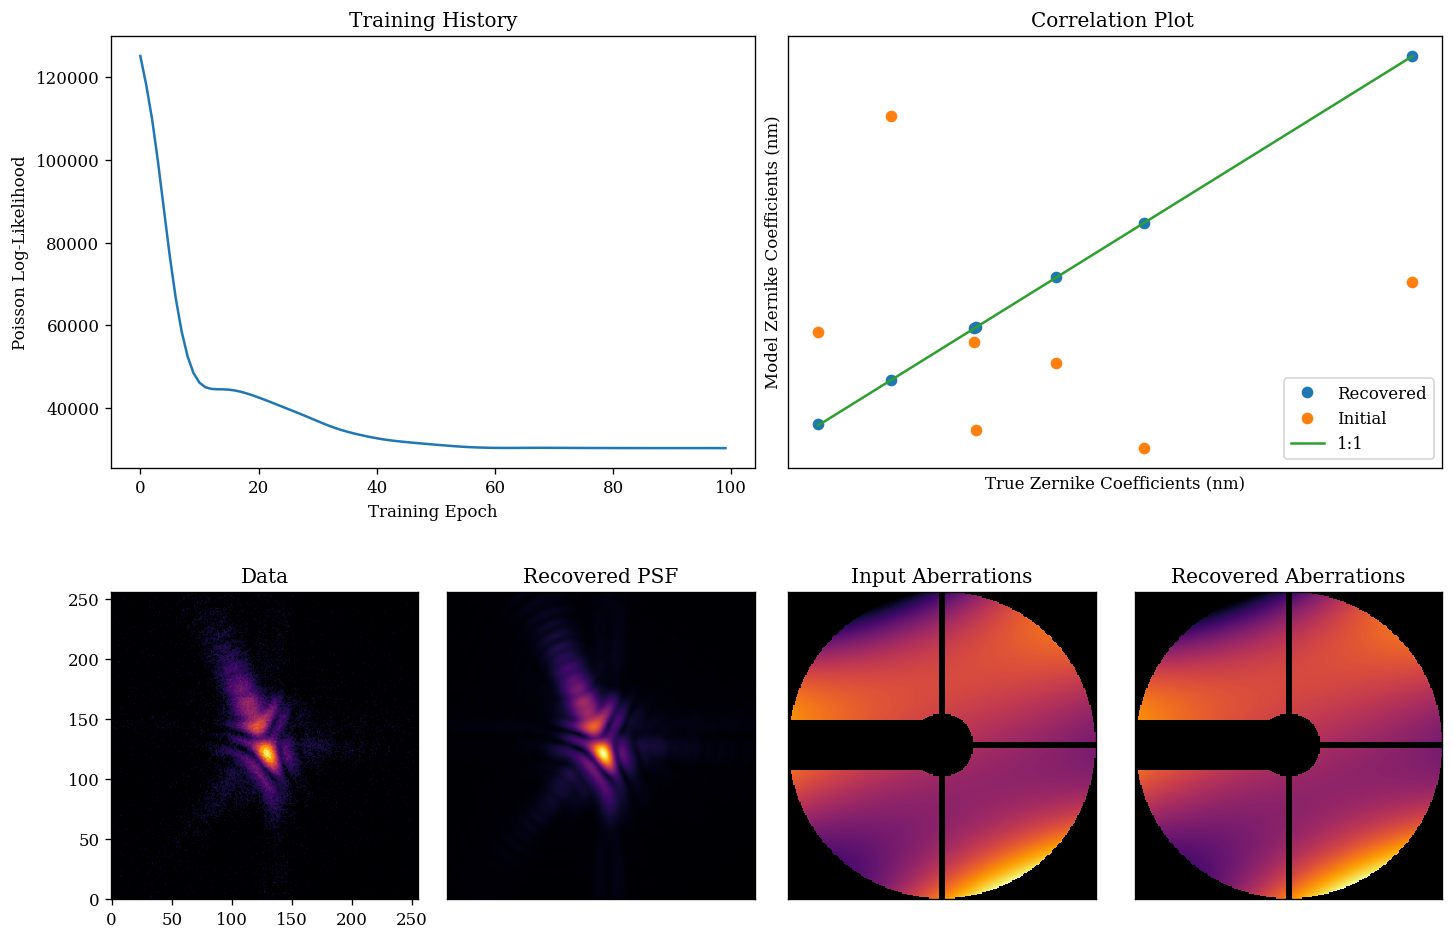

In [7]:
psf = model.model(source)
coeffs_found = np.array([model_out.get(param) for model_out in models_out])

mosaic = """
    AABB
    CDEF
    """

fig = plt.figure(constrained_layout=True,figsize=(12, 8))
axes = fig.subplot_mosaic(mosaic)

for ax in ['B','D','E','F']:
    axes[ax].set_xticks([])
    axes[ax].set_yticks([])

axes['A'].plot(np.array(losses))
axes['A'].set_title("Training History")
axes['A'].set_xlabel('Training Epoch')
axes['A'].set_ylabel('Poisson Log-Likelihood')

axes['B'].plot(coeffs*1e9, coeffs_found[-1]*1e9,'.', markersize=12,color='C0',label='Recovered')
axes['B'].plot(coeffs*1e9, coeffs_init*1e9,'.', markersize=12,color='C1',label='Initial')

axes['B'].plot(np.array([np.min(coeffs),np.max(coeffs)])*1e9,
               np.array([np.min(coeffs),np.max(coeffs)])*1e9,
               '-',color='C2',label='1:1')
axes['B'].legend()
axes['B'].set_title('Correlation Plot ')
axes['B'].set_xlabel('True Zernike Coefficients (nm)')
axes['B'].set_ylabel('Model Zernike Coefficients (nm)')

axes['C'].imshow(data**0.5)
axes['C'].set_title('Data')

axes['D'].imshow(psf**0.5)
axes['D'].set_title('Recovered PSF')

axes['E'].imshow(support_mask*opd, cmap=cmap)
axes['E'].set_title('Input Aberrations')

axes['F'].imshow(support_mask*model.aberrations.get_opd(), cmap=cmap)
axes['F'].set_title('Recovered Aberrations')
plt.show()